In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from cycler import cycler

moss_green_qualitative = [
    "#2F5D50", "#4F7F6A", "#6B8F71", "#8FAF9A",
    "#A8C3A0", "#5B6F4E", "#7A8C61", "#9BB28A",
]
moss_green_dark = ["#1F3F36", "#2F5D50", "#3E6F5C", "#4F7F6A", "#5B6F4E"]
moss_qualitative_dark = [
    "#1F3F36",  # dark moss
    "#4A6C8C",  # slate blue
    "#5B6F4E",  # olive bark
    "#7A5C61",  # muted clay
    "#3F5F5B",  # dark teal
]

moss_cmap = ListedColormap(moss_green_qualitative, name="moss_green_qualitative")
moss_cmap_dark = ListedColormap(moss_qualitative_dark, name="moss_qualitative_dark")

# Register (force=True avoids “already registered” errors in notebooks)
mpl.colormaps.register(moss_cmap, force=True)
mpl.colormaps.register(moss_cmap_dark, force=True)

# ---- Style settings (Nature-like) ----
plt.rcParams.update({
    # Text fonts
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],

    # Math fonts
    "mathtext.fontset": "stix",
    "mathtext.rm": "Times New Roman",
    "mathtext.it": "Times New Roman:italic",
    "mathtext.bf": "Times New Roman:bold",

    # Sizes
    "font.size": 12,
    "axes.labelsize": 13,
    "axes.titlesize": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,

    # Style
    "axes.linewidth": 0.8,
    "xtick.direction": "out",
    "ytick.direction": "out",

    # Color
    "axes.prop_cycle": cycler(color=moss_qualitative_dark),
})

In [18]:
# Pixart Sigma
activations = torch.load("extractions/activations.pt")
print(activations.keys())
# layer = "ff.net.0.proj"
layer = "attn1.to_q"
xt = activations[f'transformer_blocks.0.{layer}']

dict_keys(['transformer_blocks.0.attn1.to_q', 'transformer_blocks.0.attn1.to_k', 'transformer_blocks.0.attn1.to_v', 'transformer_blocks.0.attn1.to_out.0', 'transformer_blocks.0.attn2.to_q', 'transformer_blocks.0.attn2.to_k', 'transformer_blocks.0.attn2.to_v', 'transformer_blocks.0.attn2.to_out.0', 'transformer_blocks.0.ff.net.0.proj', 'transformer_blocks.0.ff.net.2'])


In [19]:
def smooth_histogram(hist, kernel_size=5):
    kernel = torch.ones(kernel_size) / kernel_size
    padded_hist = F.pad(hist.unsqueeze(0).unsqueeze(0), (kernel_size // 2, kernel_size // 2), mode='reflect')
    smoothed_hist = F.conv1d(padded_hist, kernel.unsqueeze(0).unsqueeze(0)).squeeze()
    return smoothed_hist

In [34]:
x_t = xt[0][0].permute(1, 0).float() # [1152, 4096]
var_x = x_t.var(dim=1)
x = x_t[var_x.argmax()]
hist, bin_edges = torch.histogram(x, bins=256)
step_size = bin_edges[1] - bin_edges[0]

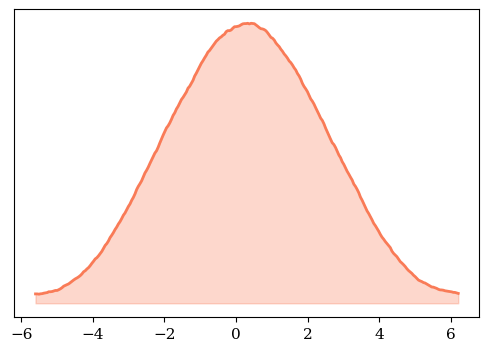

In [58]:
oryel = ["#ecda9a","#efc47e","#f3ad6a","#f7945d","#f97b57","#f66356","#ee4d5a"]
emrld = ["#d3f2a3","#97e196","#6cc08b","#4c9b82","#217a79","#105965","#074050"]

y = smooth_histogram(hist, kernel_size=100)[:-1]
step_item = torch.zeros_like(y)
step_item[122] = y[122]
# step_item[123] = hist[123]

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(bin_edges[:-1].numpy(), y.numpy(), color=oryel[4], linewidth=2)
ax.fill_between(bin_edges[:-1].numpy(), y.numpy(), color=oryel[4], alpha=0.3)
# ax.fill_between(bin_edges[:-1].numpy(), step_item.numpy(), color=oryel[4])
# ax.axvline(x.mean().item(), color=emrld[4], linestyle='--', linewidth=2)
# ax.axvline((x.mean() - step_size).item(), color=emrld[2], linestyle='--', linewidth=2)
# ax.axvline((x.mean() + step_size).item(), color=emrld[2], linestyle='--', linewidth=2)
# ax.bar(bin_edges[:-1].numpy(), step_item.numpy(), width=step_size.item(), color=emrld[5], align='edge', edgecolor=emrld[6])
# ax.set_xlabel("Value (dynamic range)")
# ax.set_ylabel("Frequency")
# ax.set_title("Activation Distribution of Max Variance Channel")
# plt.tight_layout()
# Turn off y axis
ax.yaxis.set_visible(False)
# ax.axvline(0, color="black", linestyle='-', linewidth=2)
# ax.axhline(0, color="black", linestyle='-', linewidth=2)
plt.savefig("figs/tmp.png", dpi=300)
